In [1]:
#| export

import kagglehub

import os
import io
import re
import random
import base64
import pandas as pd
from io import BytesIO
import sys
import json
import asyncio
from typing import Optional

import time
from datetime import timedelta

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F

from IPython.display import SVG

from PIL import Image
import cv2

In [2]:
import ast
import io
import math
import statistics
import string

import cairosvg
import clip
import cv2
import kagglehub
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from more_itertools import chunked
from PIL import Image, ImageFilter
from transformers import (
    AutoProcessor,
    BitsAndBytesConfig,
    PaliGemmaForConditionalGeneration,
)

svg_constraints = kagglehub.package_import('metric/svg-constraints')


class ParticipantVisibleError(Exception):
    pass


def score(
    solution: pd.DataFrame, submission: pd.DataFrame, row_id_column_name: str, random_seed: int = 0,
) -> float:
    """Calculates a fidelity score by comparing generated SVG images to target text descriptions.

    Parameters
    ----------
    solution : pd.DataFrame
        A DataFrame containing target questions, choices, and answers about an SVG image.
    submission : pd.DataFrame
        A DataFrame containing generated SVG strings. Must have a column named 'svg'.
    row_id_column_name : str
        The name of the column containing row identifiers. This column is removed before scoring.
    random_seed : int
        A seed to set the random state.

    Returns
    -------
    float
        The mean fidelity score (a value between 0 and 1) representing the average similarity between the generated SVGs and their descriptions.
        A higher score indicates better fidelity.

    Raises
    ------
    ParticipantVisibleError
        If the 'svg' column in the submission DataFrame is not of string type or if validation of the SVG fails.

    Examples
    --------
    >>> import pandas as pd
    >>> solution = pd.DataFrame({
    ...     'id': ["abcde"],
    ...     'question': ['["Is there a red circle?", "What shape is present?"]'],
    ...     'choices': ['[["yes", "no"], ["square", "circle", "triangle", "hexagon"]]'],
    ...     'answer': ['["yes", "circle"]'],
    ... })
    >>> submission = pd.DataFrame({
    ...     'id': ["abcde"],
    ...     'svg': ['<svg viewBox="0 0 100 100"><circle cx="50" cy="50" r="40" fill="red"/></svg>'],
    ... })
    >>> score(solution, submission, 'row_id', random_seed=42)
    0...
    """
    # Convert solution fields to list dtypes and expand
    for colname in ['question', 'choices', 'answer']:
        solution[colname] = solution[colname].apply(ast.literal_eval)
    solution = solution.explode(['question', 'choices', 'answer'])

    # Validate
    if not pd.api.types.is_string_dtype(submission.loc[:, 'svg']):
        raise ParticipantVisibleError('svg must be a string.')

    # Check that SVG code meets defined constraints
    constraints = svg_constraints.SVGConstraints()
    try:
        for svg in submission.loc[:, 'svg']:
            constraints.validate_svg(svg)
    except:
        raise ParticipantVisibleError('SVG code violates constraints.')

    # Score
    # vqa_evaluator = VQAEvaluator()
    # aesthetic_evaluator = AestheticEvaluator()

    results = []
    rng = np.random.RandomState(random_seed)
    # try:
    df = solution.merge(submission, on='id')
    for i, (_, group) in enumerate(df.loc[
        :, ['id', 'question', 'choices', 'answer', 'svg']
    ].groupby('id')):
        questions, choices, answers, svg = [
            group[col_name].to_list()
            for col_name in group.drop('id', axis=1).columns
        ]
        svg = svg[0]  # unpack singleton from list
        group_seed = rng.randint(0, np.iinfo(np.int32).max)
        image_processor = ImageProcessor(image=svg_to_png(svg), seed=group_seed).apply()
        image = image_processor.image.copy()
        aesthetic_score = aesthetic_evaluator.score(image)
        vqa_score = vqa_evaluator.score(questions, choices, answers, image)
        image_processor.reset().apply_random_crop_resize().apply_jpeg_compression(quality=90)
        ocr_score = vqa_evaluator.ocr(image_processor.image)
        instance_score = (
            harmonic_mean(vqa_score, aesthetic_score, beta=0.5) * ocr_score
        )
        results.append(instance_score)

    # except:
    #     raise ParticipantVisibleError('SVG failed to score.')
#---------------Modified output of function--------------------#
    
    fidelity = statistics.mean(results)
    return float(fidelity), vqa_score, aesthetic_score, ocr_score


class VQAEvaluator:
    """Evaluates images based on their similarity to a given text description using multiple choice questions."""

    def __init__(self):
        self.quantization_config = BitsAndBytesConfig(
            load_in_4bit=True,
            bnb_4bit_quant_type='nf4',
            bnb_4bit_use_double_quant=True,
            bnb_4bit_compute_dtype=torch.float16,
        )
        self.letters = string.ascii_uppercase
        self.model_path = kagglehub.model_download(
            'google/paligemma-2/transformers/paligemma2-10b-mix-448'
        )
        self.processor = AutoProcessor.from_pretrained(self.model_path)
        self.model = PaliGemmaForConditionalGeneration.from_pretrained(
            self.model_path,
            low_cpu_mem_usage=True,
            quantization_config=self.quantization_config,
        ).to('cuda:0')

    def score(self, questions, choices, answers, image, n=4):
        scores = []
        batches = (chunked(qs, n) for qs in [questions, choices, answers])
        for question_batch, choice_batch, answer_batch in zip(*batches, strict=True):
            scores.extend(
                self.score_batch(
                    image,
                    question_batch,
                    choice_batch,
                    answer_batch,
                )
            )
        return statistics.mean(scores)

    def score_batch(
        self,
        image: Image.Image,
        questions: list[str],
        choices_list: list[list[str]],
        answers: list[str],
    ) -> list[float]:
        """Evaluates the image based on multiple choice questions and answers.

        Parameters
        ----------
        image : PIL.Image.Image
            The image to evaluate.
        questions : list[str]
            List of questions about the image.
        choices_list : list[list[str]]
            List of lists of possible answer choices, corresponding to each question.
        answers : list[str]
            List of correct answers from the choices, corresponding to each question.

        Returns
        -------
        list[float]
            List of scores (values between 0 and 1) representing the probability of the correct answer for each question.
        """
        prompts = [
            self.format_prompt(question, choices)
            for question, choices in zip(questions, choices_list, strict=True)
        ]
        batched_choice_probabilities = self.get_choice_probability(
            image, prompts, choices_list
        )

        scores = []
        for i, _ in enumerate(questions):
            choice_probabilities = batched_choice_probabilities[i]
            answer = answers[i]
            answer_probability = 0.0
            for choice, prob in choice_probabilities.items():
                if choice == answer:
                    answer_probability = prob
                    break
            scores.append(answer_probability)

        return scores

    def format_prompt(self, question: str, choices: list[str]) -> str:
        prompt = f'<image>answer en Question: {question}\nChoices:\n'
        for i, choice in enumerate(choices):
            prompt += f'{self.letters[i]}. {choice}\n'
        return prompt

    def mask_choices(self, logits, choices_list):
        """Masks logits for the first token of each choice letter for each question in the batch."""
        batch_size = logits.shape[0]
        masked_logits = torch.full_like(logits, float('-inf'))

        for batch_idx in range(batch_size):
            choices = choices_list[batch_idx]
            for i in range(len(choices)):
                letter_token = self.letters[i]

                first_token = self.processor.tokenizer.encode(
                    letter_token, add_special_tokens=False
                )[0]
                first_token_with_space = self.processor.tokenizer.encode(
                    ' ' + letter_token, add_special_tokens=False
                )[0]

                if isinstance(first_token, int):
                    masked_logits[batch_idx, first_token] = logits[
                        batch_idx, first_token
                    ]
                if isinstance(first_token_with_space, int):
                    masked_logits[batch_idx, first_token_with_space] = logits[
                        batch_idx, first_token_with_space
                    ]

        return masked_logits

    def get_choice_probability(self, image, prompts, choices_list) -> list[dict]:
        inputs = self.processor(
            images=[image] * len(prompts),
            text=prompts,
            return_tensors='pt',
            padding='longest',
        ).to('cuda:0')

        with torch.no_grad():
            outputs = self.model(**inputs)
            logits = outputs.logits[:, -1, :]  # Logits for the last (predicted) token
            masked_logits = self.mask_choices(logits, choices_list)
            probabilities = torch.softmax(masked_logits, dim=-1)

        batched_choice_probabilities = []
        for batch_idx in range(len(prompts)):
            choice_probabilities = {}
            choices = choices_list[batch_idx]
            for i, choice in enumerate(choices):
                letter_token = self.letters[i]
                first_token = self.processor.tokenizer.encode(
                    letter_token, add_special_tokens=False
                )[0]
                first_token_with_space = self.processor.tokenizer.encode(
                    ' ' + letter_token, add_special_tokens=False
                )[0]

                prob = 0.0
                if isinstance(first_token, int):
                    prob += probabilities[batch_idx, first_token].item()
                if isinstance(first_token_with_space, int):
                    prob += probabilities[batch_idx, first_token_with_space].item()
                choice_probabilities[choice] = prob

            # Renormalize probabilities for each question
            total_prob = sum(choice_probabilities.values())
            if total_prob > 0:
                renormalized_probabilities = {
                    choice: prob / total_prob
                    for choice, prob in choice_probabilities.items()
                }
            else:
                renormalized_probabilities = (
                    choice_probabilities  # Avoid division by zero if total_prob is 0
                )
            batched_choice_probabilities.append(renormalized_probabilities)

        return batched_choice_probabilities

    def ocr(self, image, free_chars=4):
        inputs = (
            self.processor(
                text='<image>ocr\n',
                images=image,
                return_tensors='pt',
            )
            .to(torch.float16)
            .to(self.model.device)
        )
        input_len = inputs['input_ids'].shape[-1]

        with torch.inference_mode():
            outputs = self.model.generate(**inputs, max_new_tokens=32, do_sample=False)
            outputs = outputs[0][input_len:]
            decoded = self.processor.decode(outputs, skip_special_tokens=True)

        num_char = len(decoded)

        # Exponentially decreasing towards 0.0 if more than free_chars detected
        return min(1.0, math.exp(-num_char + free_chars))


class AestheticPredictor(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.input_size = input_size
        self.layers = nn.Sequential(
            nn.Linear(self.input_size, 1024),
            nn.Dropout(0.2),
            nn.Linear(1024, 128),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.Dropout(0.1),
            nn.Linear(64, 16),
            nn.Linear(16, 1),
        )

    def forward(self, x):
        return self.layers(x)


class AestheticEvaluator:
    def __init__(self):

# -----------------modified paths for packaging!!!!-----------------
        self.model_path = kagglehub.notebook_output_download(
            'metric/sac-logos-ava1-l14-linearmse'
        ) + '/sac+logos+ava1-l14-linearMSE.pth'

        self.clip_model_path = kagglehub.notebook_output_download(
            'metric/openai-clip-vit-large-patch14'
        ) + '/ViT-L-14.pt'

        self.predictor, self.clip_model, self.preprocessor = self.load()
        
    def load(self):
        """Loads the aesthetic predictor model and CLIP model."""
        state_dict = torch.load(self.model_path, weights_only=True, map_location='cuda:1')

        # CLIP embedding dim is 768 for CLIP ViT L 14
        predictor = AestheticPredictor(768)
        predictor.load_state_dict(state_dict)
        predictor.to('cuda:1')
        predictor.eval()
        clip_model, preprocessor = clip.load(self.clip_model_path, device='cuda:1')

        return predictor, clip_model, preprocessor

    def score(self, image: Image.Image) -> float:
        """Predicts the CLIP aesthetic score of an image."""
        image = self.preprocessor(image).unsqueeze(0).to('cuda:1')

        with torch.no_grad():
            image_features = self.clip_model.encode_image(image)
            # l2 normalize
            image_features /= image_features.norm(dim=-1, keepdim=True)
            image_features = image_features.cpu().detach().numpy()

        score = self.predictor(torch.from_numpy(image_features).to('cuda:1').float())

        return score.item() / 10.0  # scale to [0, 1]


def harmonic_mean(a: float, b: float, beta: float = 1.0) -> float:
    """
    Calculate the harmonic mean of two values, weighted using a beta parameter.

    Args:
        a: First value (e.g., precision)
        b: Second value (e.g., recall)
        beta: Weighting parameter

    Returns:
        Weighted harmonic mean
    """
    # Handle zero values to prevent division by zero
    if a <= 0 or b <= 0:
        return 0.0
    return (1 + beta**2) * (a * b) / (beta**2 * a + b)


def svg_to_png(svg_code: str, size: tuple = (384, 384)) -> Image.Image:
    """
    Converts an SVG string to a PNG image using CairoSVG.

    If the SVG does not define a `viewBox`, it will add one using the provided size.

    Parameters
    ----------
    svg_code : str
        The SVG string to convert.
    size : tuple[int, int], default=(384, 384)
        The desired size of the output PNG image (width, height).

    Returns
    -------
    PIL.Image.Image
        The generated PNG image.
    """
    # Ensure SVG has proper size attributes
    if 'viewBox' not in svg_code:
        svg_code = svg_code.replace('<svg', f'<svg viewBox="0 0 {size[0]} {size[1]}"')

    # Convert SVG to PNG
    png_data = cairosvg.svg2png(bytestring=svg_code.encode('utf-8'))
    return Image.open(io.BytesIO(png_data)).convert('RGB').resize(size)


class ImageProcessor:
    def __init__(self, image: Image.Image, seed=None):
        """Initialize with either a path to an image or a PIL Image object."""
        self.image = image
        self.original_image = self.image.copy()
        if seed is not None:
            self.rng = np.random.RandomState(seed)
        else:
            self.rng = np.random

    def reset(self):
        self.image = self.original_image.copy()
        return self
    
    def visualize_comparison(
        self,
        original_name='Original',
        processed_name='Processed',
        figsize=(10, 5),
        show=True,
    ):
        """Display original and processed images side by side."""
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
        ax1.imshow(np.asarray(self.original_image))
        ax1.set_title(original_name)
        ax1.axis('off')

        ax2.imshow(np.asarray(self.image))
        ax2.set_title(processed_name)
        ax2.axis('off')

        title = f'{original_name} vs {processed_name}'
        fig.suptitle(title)
        fig.tight_layout()
        if show:
            plt.show()
        return fig

    def apply_median_filter(self, size=3):
        """Apply median filter to remove outlier pixel values.

        Args:
            size: Size of the median filter window.
        """
        self.image = self.image.filter(ImageFilter.MedianFilter(size=size))
        return self

    def apply_bilateral_filter(self, d=9, sigma_color=75, sigma_space=75):
        """Apply bilateral filter to smooth while preserving edges.

        Args:
            d: Diameter of each pixel neighborhood
            sigma_color: Filter sigma in the color space
            sigma_space: Filter sigma in the coordinate space
        """
        # Convert PIL Image to numpy array for OpenCV
        img_array = np.asarray(self.image)

        # Apply bilateral filter
        filtered = cv2.bilateralFilter(img_array, d, sigma_color, sigma_space)

        # Convert back to PIL Image
        self.image = Image.fromarray(filtered)
        return self

    def apply_fft_low_pass(self, cutoff_frequency=0.5):
        """Apply low-pass filter in the frequency domain using FFT.

        Args:
            cutoff_frequency: Normalized cutoff frequency (0-1).
                Lower values remove more high frequencies.
        """
        # Convert to numpy array, ensuring float32 for FFT
        img_array = np.array(self.image, dtype=np.float32)

        # Process each color channel separately
        result = np.zeros_like(img_array)
        for i in range(3):  # For RGB channels
            # Apply FFT
            f = np.fft.fft2(img_array[:, :, i])
            fshift = np.fft.fftshift(f)

            # Create a low-pass filter mask
            rows, cols = img_array[:, :, i].shape
            crow, ccol = rows // 2, cols // 2
            mask = np.zeros((rows, cols), np.float32)
            r = int(min(crow, ccol) * cutoff_frequency)
            center = [crow, ccol]
            x, y = np.ogrid[:rows, :cols]
            mask_area = (x - center[0]) ** 2 + (y - center[1]) ** 2 <= r * r
            mask[mask_area] = 1

            # Apply mask and inverse FFT
            fshift_filtered = fshift * mask
            f_ishift = np.fft.ifftshift(fshift_filtered)
            img_back = np.fft.ifft2(f_ishift)
            img_back = np.real(img_back)

            result[:, :, i] = img_back

        # Clip to 0-255 range and convert to uint8 after processing all channels
        result = np.clip(result, 0, 255).astype(np.uint8)

        # Convert back to PIL Image
        self.image = Image.fromarray(result)
        return self

    def apply_jpeg_compression(self, quality=85):
        """Apply JPEG compression.

        Args:
            quality: JPEG quality (0-95). Lower values increase compression.
        """
        buffer = io.BytesIO()
        self.image.save(buffer, format='JPEG', quality=quality)
        buffer.seek(0)
        self.image = Image.open(buffer)
        return self

    def apply_random_crop_resize(self, crop_percent=0.05):
        """Randomly crop and resize back to original dimensions.

        Args:
            crop_percent: Percentage of image to crop (0-0.4).
        """
        width, height = self.image.size
        crop_pixels_w = int(width * crop_percent)
        crop_pixels_h = int(height * crop_percent)

        left = self.rng.randint(0, crop_pixels_w + 1)
        top = self.rng.randint(0, crop_pixels_h + 1)
        right = width - self.rng.randint(0, crop_pixels_w + 1)
        bottom = height - self.rng.randint(0, crop_pixels_h + 1)

        self.image = self.image.crop((left, top, right, bottom))
        self.image = self.image.resize((width, height), Image.BILINEAR)
        return self

    def apply(self):
        """Apply an ensemble of defenses."""
        return (
            self.apply_random_crop_resize(crop_percent=0.03)
            .apply_jpeg_compression(quality=95)
            .apply_median_filter(size=9)
            .apply_fft_low_pass(cutoff_frequency=0.5)
            .apply_bilateral_filter(d=5, sigma_color=75, sigma_space=75)
            .apply_jpeg_compression(quality=92)
        )

# Load evaluator

In [3]:
vqa_evaluator = VQAEvaluator()
aesthetic_evaluator = AestheticEvaluator()

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

# Image -> SVG

In [4]:
def compress_hex_color(hex_color):
    """Convert hex color to shortest possible representation"""
    r, g, b = int(hex_color[1:3], 16), int(hex_color[3:5], 16), int(hex_color[5:7], 16)
    if r % 17 == 0 and g % 17 == 0 and b % 17 == 0:
        return f'#{r//17:x}{g//17:x}{b//17:x}'
    return hex_color

def extract_features_by_scale(img_np, num_colors=16):
    """
    Extract image features hierarchically by scale
    
    Args:
        img_np (np.ndarray): Input image
        num_colors (int): Number of colors to quantize
    
    Returns:
        list: Hierarchical features sorted by importance
    """
    # Convert to RGB if needed
    if len(img_np.shape) == 3 and img_np.shape[2] > 1:
        img_rgb = img_np
    else:
        img_rgb = cv2.cvtColor(img_np, cv2.COLOR_GRAY2RGB)
    
    # Convert to grayscale for processing
    gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)
    height, width = gray.shape
    
    # Perform color quantization
    pixels = img_rgb.reshape(-1, 3).astype(np.float32)
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
    _, labels, centers = cv2.kmeans(pixels, num_colors, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
    
    # Quantized image
    palette = centers.astype(np.uint8)
    quantized = palette[labels.flatten()].reshape(img_rgb.shape)
    
    # Hierarchical feature extraction
    hierarchical_features = []
    
    # Sort colors by frequency
    unique_labels, counts = np.unique(labels, return_counts=True)
    sorted_indices = np.argsort(-counts)
    sorted_colors = [palette[i] for i in sorted_indices]
    
    # Center point for importance calculations
    center_x, center_y = width/2, height/2
    
    for color in sorted_colors:
        # Create color mask
        color_mask = cv2.inRange(quantized, color, color)
        
        # Find contours
        contours, _ = cv2.findContours(color_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        # Sort contours by area (largest first)
        contours = sorted(contours, key=cv2.contourArea, reverse=True)
        
        # Convert RGB to compressed hex
        hex_color = compress_hex_color(f'#{color[0]:02x}{color[1]:02x}{color[2]:02x}')
        
        color_features = []
        for contour in contours:
            # Skip tiny contours
            area = cv2.contourArea(contour)
            if area < 20:
                continue
            
            # Calculate contour center
            m = cv2.moments(contour)
            if m["m00"] == 0:
                continue
            
            cx = int(m["m10"] / m["m00"])
            cy = int(m["m01"] / m["m00"])
            
            # Distance from image center (normalized)
            dist_from_center = np.sqrt(((cx - center_x) / width)**2 + ((cy - center_y) / height)**2)
            
            # Simplify contour
            epsilon = 0.02 * cv2.arcLength(contour, True)
            approx = cv2.approxPolyDP(contour, epsilon, True)
            
            # Generate points string
            points = " ".join([f"{pt[0][0]:.1f},{pt[0][1]:.1f}" for pt in approx])
            
            # Calculate importance (area, proximity to center, complexity)
            importance = (
                area * 
                (1 - dist_from_center) * 
                (1 / (len(approx) + 1))
            )
            
            color_features.append({
                'points': points,
                'color': hex_color,
                'area': area,
                'importance': importance,
                'point_count': len(approx),
                'original_contour': approx  # Store original contour for adaptive simplification
            })
        
        # Sort features by importance within this color
        color_features.sort(key=lambda x: x['importance'], reverse=True)
        hierarchical_features.extend(color_features)
    
    # Final sorting by overall importance
    hierarchical_features.sort(key=lambda x: x['importance'], reverse=True)
    
    return hierarchical_features

def simplify_polygon(points_str, simplification_level):
    """
    Simplify a polygon by reducing coordinate precision or number of points
    
    Args:
        points_str (str): Space-separated "x,y" coordinates
        simplification_level (int): Level of simplification (0-3)
    
    Returns:
        str: Simplified points string
    """
    if simplification_level == 0:
        return points_str
    
    points = points_str.split()
    
    # Level 1: Round to 1 decimal place
    if simplification_level == 1:
        return " ".join([f"{float(p.split(',')[0]):.1f},{float(p.split(',')[1]):.1f}" for p in points])
    
    # Level 2: Round to integer
    if simplification_level == 2:
        return " ".join([f"{float(p.split(',')[0]):.0f},{float(p.split(',')[1]):.0f}" for p in points])
    
    # Level 3: Reduce number of points (keep every other point, but ensure at least 3 points)
    if simplification_level == 3:
        if len(points) <= 4:
            # If 4 or fewer points, just round to integer
            return " ".join([f"{float(p.split(',')[0]):.0f},{float(p.split(',')[1]):.0f}" for p in points])
        else:
            # Keep approximately half the points, but maintain at least 3
            step = min(2, len(points) // 3)
            reduced_points = [points[i] for i in range(0, len(points), step)]
            # Ensure we keep at least 3 points and the last point
            if len(reduced_points) < 3:
                reduced_points = points[:3]
            if points[-1] not in reduced_points:
                reduced_points.append(points[-1])
            return " ".join([f"{float(p.split(',')[0]):.0f},{float(p.split(',')[1]):.0f}" for p in reduced_points])
    
    return points_str

def bitmap_to_svg_layered(image, max_size_bytes=10000, resize=True, target_size=(384, 384), 
                         adaptive_fill=True, num_colors=None):
    """
    Convert bitmap to SVG using layered feature extraction with optimized space usage
    
    Args:
        image: Input image (PIL.Image)
        max_size_bytes (int): Maximum SVG size
        resize (bool): Whether to resize the image before processing
        target_size (tuple): Target size for resizing (width, height)
        adaptive_fill (bool): Whether to adaptively fill available space
        num_colors (int): Number of colors to quantize, if None uses adaptive selection
    
    Returns:
        str: SVG representation
    """
    # Adaptive color selection based on image complexity
    if num_colors is None:
        # Simple heuristic: more colors for complex images
        if resize:
            pixel_count = target_size[0] * target_size[1]
        else:
            pixel_count = image.size[0] * image.size[1]
        
        if pixel_count < 65536:  # 256x256
            num_colors = 8
        elif pixel_count < 262144:  # 512x512
            num_colors = 12
        else:
            num_colors = 16
    
    # Resize the image if requested
    if resize:
        original_size = image.size
        image = image.resize(target_size, Image.LANCZOS)
    else:
        original_size = image.size
    
    # Convert to numpy array
    img_np = np.array(image)
    
    # Get image dimensions
    height, width = img_np.shape[:2]
    
    # Calculate average background color
    if len(img_np.shape) == 3 and img_np.shape[2] == 3:
        avg_bg_color = np.mean(img_np, axis=(0,1)).astype(int)
        bg_hex_color = compress_hex_color(f'#{avg_bg_color[0]:02x}{avg_bg_color[1]:02x}{avg_bg_color[2]:02x}')
    else:
        bg_hex_color = '#fff'
    
    # Start building SVG
    # Use original dimensions in viewBox for proper scaling when displayed
    orig_width, orig_height = original_size
    svg_header = f'<svg width="{orig_width}" height="{orig_height}" viewBox="0 0 {width} {height}">\n'
    svg_bg = f'<rect width="{width}" height="{height}" fill="{bg_hex_color}"/>\n'
    svg_base = svg_header + svg_bg
    svg_footer = '</svg>'
    
    # Calculate base size
    base_size = len((svg_base + svg_footer).encode('utf-8'))
    available_bytes = max_size_bytes - base_size
    
    # Extract hierarchical features
    features = extract_features_by_scale(img_np, num_colors=num_colors)
    
    # If not using adaptive fill, just add features until we hit the limit
    if not adaptive_fill:
        svg = svg_base
        for feature in features:
            # Try adding the feature
            feature_svg = f'<polygon points="{feature["points"]}" fill="{feature["color"]}" />\n'
            
            # Check if adding this feature exceeds size limit
            if len((svg + feature_svg + svg_footer).encode('utf-8')) > max_size_bytes:
                break
            
            # Add the feature
            svg += feature_svg
        
        # Close SVG
        svg += svg_footer
        return svg
    
    # For adaptive fill, use binary search to find optimal simplification level
    
    # First attempt: calculate size of all features at different simplification levels
    feature_sizes = []
    for feature in features:
        feature_sizes.append({
            'original': len(f'<polygon points="{feature["points"]}" fill="{feature["color"]}" />\n'.encode('utf-8')),
            'level1': len(f'<polygon points="{simplify_polygon(feature["points"], 1)}" fill="{feature["color"]}" />\n'.encode('utf-8')),
            'level2': len(f'<polygon points="{simplify_polygon(feature["points"], 2)}" fill="{feature["color"]}" />\n'.encode('utf-8')),
            'level3': len(f'<polygon points="{simplify_polygon(feature["points"], 3)}" fill="{feature["color"]}" />\n'.encode('utf-8'))
        })
    
    # Two-pass approach: first add most important features, then fill remaining space
    svg = svg_base
    bytes_used = base_size
    added_features = set()
    
    # Pass 1: Add most important features at original quality
    for i, feature in enumerate(features):
        feature_svg = f'<polygon points="{feature["points"]}" fill="{feature["color"]}" />\n'
        feature_size = feature_sizes[i]['original']
        
        if bytes_used + feature_size <= max_size_bytes:
            svg += feature_svg
            bytes_used += feature_size
            added_features.add(i)
    
    # Pass 2: Try to add remaining features with progressive simplification
    for level in range(1, 4):  # Try simplification levels 1-3
        for i, feature in enumerate(features):
            if i in added_features:
                continue
                
            feature_size = feature_sizes[i][f'level{level}']
            if bytes_used + feature_size <= max_size_bytes:
                feature_svg = f'<polygon points="{simplify_polygon(feature["points"], level)}" fill="{feature["color"]}" />\n'
                svg += feature_svg
                bytes_used += feature_size
                added_features.add(i)
    
    # Finalize SVG
    svg += svg_footer
    
    # Double check we didn't exceed limit
    final_size = len(svg.encode('utf-8'))
    if final_size > max_size_bytes:
        # If we somehow went over, return basic SVG
        return f'<svg xmlns="http://www.w3.org/2000/svg" viewBox="0 0 {width} {height}"><rect width="{width}" height="{height}" fill="{bg_hex_color}"/></svg>'
    
    # Calculate space utilization
    utilization = (final_size / max_size_bytes) * 100
    
    # Return the SVG with efficient space utilization
    return svg

# Load Data

In [5]:
PATH_TO_DESCRIPTION = r"/kaggle/input/drawing-with-llms/train.csv"
PATH_TO_QUESTION = r"/kaggle/input/drawing-with-llms/questions.parquet"
train_descriptions = pd.read_csv(PATH_TO_DESCRIPTION)
train_questions = pd.read_parquet(PATH_TO_QUESTION)

train_questions = train_questions.groupby("id").agg({
    "question" : list,
    "choices" : list,
    "answer" : list
}).reset_index()

train_df = pd.merge(train_questions, train_descriptions, how= 'left', on= 'id')

#| export

def convert_to_json(value):
    return json.dumps(value)
    
def convert_data_to_solution(idx, data):
    # Retrieve the corresponding row based on idx_prompt
    row = data.loc[data["id"] == idx].iloc[0]

    # Extract values from the row
    idx, description, question, choices, answer = (
        row["id"], row["description"], row["question"], row["choices"], row["answer"]
    )

    # Convert choices and answer into a valid list of strings
    choices = [choice.tolist() for choice in choices]
    choices = convert_to_json(choices)
    answer = list(map(str, answer)) if isinstance(answer, list) else [str(answer)]

    # Format data for evaluation
    solution = pd.DataFrame({
        "id": [idx],
        "question": [json.dumps(question)],  # Convert question to a JSON string
        "choices": choices,   # Convert choices to a JSON string
        "answer": [json.dumps(answer)]      # Convert answer to a JSON string
    })
    
    return solution
    

# Load Flux

In [6]:
import torch
from diffusers import FluxPipeline
import kagglehub

flux_path = kagglehub.model_download("jwadow/flux.1-dev/other/default/5")

pipe = FluxPipeline.from_pretrained(
    flux_path,
    torch_dtype=torch.bfloat16,  # hoặc float16 nếu không dùng bf16
    device_map="balanced",       # Tự động chia lên 2 GPU + CPU
    max_memory={
        0: "5GiB",               # GPU 0
        1: "15GiB",               # GPU 1
        "cpu": "20GiB"            # RAM
    }
)


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

You set `add_prefix_space`. The tokenizer needs to be converted from the slow tokenizers


# Image compression with KMean

In [7]:
#| export

import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from PIL import Image

def image_compression(image_input, k=6):
    """
    Compress an image using the K-Means clustering algorithm.

    Parameters:
        image_input (str or numpy array or PIL.Image): Path to the input image, an image array, or a PIL image.
        k (int): Number of color clusters (default is 8).

    Returns:
        compressed_image (PIL.Image.Image): The compressed image in PIL format.
    """
    # Check if input is a file path (string), PIL image or numpy array
    if isinstance(image_input, str):
        image = cv2.imread(image_input)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB
    elif isinstance(image_input, Image.Image):  # If input is a PIL image
        image = np.array(image_input)  # Convert PIL image to NumPy array
    else:
        image = image_input  # If input is already a NumPy array

    # Ensure image is in RGB format
    if image.ndim == 3 and image.shape[2] == 4:  # If the image has alpha channel (RGBA)
        image = image[:, :, :3]  # Remove alpha channel to get RGB
    
    # Reshape the image into a 2D array (num_pixels, 3)
    pixels = image.reshape((-1, 3))
    
    # Apply K-Means clustering
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(pixels)
    
    # Replace each pixel with the color of its nearest cluster center
    compressed_pixels = kmeans.cluster_centers_[kmeans.labels_]
    compressed_image = compressed_pixels.reshape(image.shape).astype(np.uint8)
    
    # Convert the result back to PIL.Image
    compressed_image_pil = Image.fromarray(compressed_image)
    
    return compressed_image_pil


# Generate Image

In [8]:
def generate_bitmap(prompt: str, height: int = 400, width: int = 320, guidance_scale: float = 10.0,
                    num_inference_steps: int = 5, max_sequence_length: int = 512):
    """
    Generate a bitmap image from a text prompt using the FluxPipeline.

    Args:
        prompt (str): Text description to generate the image from.
        height (int, optional): Height of the generated image in pixels. Defaults to 400.
        width (int, optional): Width of the generated image in pixels. Defaults to 320.
        guidance_scale (float, optional): Strength of guidance to follow the prompt. Higher values follow the prompt more strictly. Defaults to 3.5.
        num_inferecne_steps (int, optional): Number of denoising steps for generation. Defaults to 50.
        max_sequence_length (int, optional): Maximum length of the tokenized prompt. Defaults to 512.

    Returns:
        PIL.Image.Image: The generated image as a PIL image.
    """
    image = pipe(
        prompt,
        height=height,
        width=width,
        guidance_scale=guidance_scale,
        num_inference_steps=num_inference_steps,
        max_sequence_length=max_sequence_length,
        # generator=torch.Generator("cpu").manual_seed(0)
    )

    return image.images[0]


# Generate and Evaluation

In [9]:
def generate_and_image_in_train(
    idx_prompt: str,
    data: pd.DataFrame,
    generate_bitmap,
    prefix_prompt: str | None, 
    negative_prompt: str | None, 
    suffix_prompt: str | None, 
    num_inference_steps: int = 20, 
    guidance_scale: float = 15.0, 
    num_attempts: int = 4,
    use_image_compression: bool = False,
    use_model: str = "SDv2",
    verbose: bool = False,
    random_seed: int = 42) -> dict:
    """
    Generates an image based on a given prompt, optionally applies image compression, 
    converts the image to an SVG format, and evaluates its quality based on multiple scores.

    Parameters:
    -----------
    idx_prompt : str
        The ID of the description in the dataset.
    data : pd.DataFrame
        A DataFrame containing descriptions, questions, choices, and answers related to the image.
    prefix_prompt : str | None
        Additional text prepended to the prompt to enhance the description.
    negative_prompt : str | None
        Text specifying elements to exclude from the generated image.
    suffix_prompt : str | None
        Additional text appended to the prompt for further modification.
    num_inference_steps : int, default=20
        The number of denoising steps during image generation. More steps typically result in higher-quality images but increase processing time.
    guidance_scale : float, default=15.0
        A scaling factor that determines how strictly the model follows the text prompt. Higher values improve adherence to the prompt but may reduce image diversity.
    num_attempts : int, default=4
        The number of attempts to generate and optimize the best output.
    use_compression_image : bool, default=False
        Whether to apply image compression before converting to SVG.
    verbose : bool, default=False
        If True, prints detailed information about the process.
    random_seed : int, default=42
        Random seed to ensure reproducibility.
    Returns:
    --------
    dict :
        A dictionary containing:
        - 'id' (str) : ID of description
        - 'total_score' (float): The highest total score achieved.
        - 'vqa_score' (float): The best Visual Question Answering (VQA) score.
        - 'aesthetic_score' (float): The best aesthetic score.
        - 'ocr_score' (float): The best Optical Character Recognition (OCR) score.
        - 'svg' (str): The SVG representation of the best-generated image.
    """

    # Cố định seed để đảm bảo tính tái lập
    random.seed(random_seed)
    np.random.seed(random_seed)
    torch.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed)
    
    #Get data for 
    description = data.loc[data['id'] == idx_prompt, 'description'].iloc[0]

    # Define variables
    best_vqa_score = 0
    best_aesthetic_score = 0
    best_ocr_score = 0
    best_total_score = 0
    best_svg = ""
    start_gen = 0
    end_gen = 0
    
    # Combines prompt
    prompt = f"{prefix_prompt} {description} {suffix_prompt}"

    for i in range(num_attempts):
        solution = convert_data_to_solution(idx_prompt, data)
        
        if verbose:
            print(f"\n=== Attempt {i+1}/{num_attempts} ===")
            print(f"Description: {description}\n")
            
        # Generate bitmap with Stable Diffusion (Use combined_prompt)
        start_gen = time.time()
        bitmap = generate_bitmap(prompt, 
                                 height = 320, 
                                 width = 320, 
                                 guidance_scale = guidance_scale,
                                 num_inference_steps = num_inference_steps, 
                                 max_sequence_length = 512)
        end_gen = time.time()
        time_gen = end_gen - start_gen
        # Convert to SVG with size limit
        if verbose: print(f"Converting to SVG... ", end = "")
            
        # Use Compression
        if use_image_compression:
            compressed_image = image_compression(bitmap, k=8)
            svg_content = bitmap_to_svg_layered(
                compressed_image,
                max_size_bytes=10000, 
                resize=True, 
                target_size=(320, 320), 
                adaptive_fill=True, 
                num_colors=12
            )
        else:
            svg_content = bitmap_to_svg_layered(
                bitmap, 
                max_size_bytes=10000, 
                resize=True, 
                target_size=(320, 320), 
                adaptive_fill=True, 
                num_colors=12
            )
    
        # Render SVG to bitmap for evaluation
        rendered_svg = svg_to_png(svg_content)
        svg_size = len(svg_content.encode('utf-8'))
        if verbose: 
            print(f"SVG size: {svg_size} bytes")

        # Formate for evalution
        submission = pd.DataFrame({
            'id' : [idx_prompt],
            'svg' : [svg_content]
        })
        
        # Compution competition_score, vqa_score, aesthetic_score, ocr_score
        total_score, vqa_score, aesthetic_score, ocr_score = score(solution, submission, 'row_id', random_seed=42)
        aesthetic_score_original = aesthetic_evaluator.score(bitmap)
        
        if use_image_compression:
            aesthetic_score_compressed = aesthetic_evaluator.score(compressed_image)
        
        # Display the images side by side
        if verbose: 
            plt.figure(figsize=(18, 6))
            
            # Original bitmap
            plt.subplot(1, 3, 1)
            plt.imshow(bitmap)
            plt.title(f"Original Image {i+1} - Aesthetic Score: {aesthetic_score_original:.4f}")
            plt.axis('off')

            if use_image_compression:
                # Compressed image
                plt.subplot(1, 3, 2)
                plt.imshow(compressed_image)
                plt.title(f"Compressed Image {i+1} - Aesthetic Score: {aesthetic_score_compressed:.4f}")
                plt.axis('off')
        
            # SVG conversion
            plt.subplot(1, 3, 3)
            plt.imshow(rendered_svg)
            plt.title(f"SVG Conversion {i+1} - Aesthetic Score: {aesthetic_score:.4f}")
            plt.axis('off')
            
            plt.tight_layout()
            plt.show()
        
        if verbose:
            print(f"Time: {time_gen}s/image")
            print(f"SVG VQA Score: {vqa_score:.4f}")
            print(f"SVG Aesthetic Score: {aesthetic_score:.4f}")
            print(f"SVG Ocr Score: {ocr_score:.4f}")
            print(f"SVG Total Score: {total_score:.4f}")

        if total_score > best_total_score:
            best_total_score = total_score
            best_vqa_score = vqa_score
            best_aesthetic_score = aesthetic_score
            best_ocr_score = ocr_score
            best_svg = svg_content
            if verbose: print(f"✅ New best result")
        else:
            if verbose: print(f"❌ Not better than current best")
                
    print("-------------------------------------------")
        
    return {
        'method' : "I->SVG" if not use_image_compression else "I->KMean->SVG",
        'model' : 'SDv2' if use_model == "SDv2" else "Flux",
        'id_desc' : idx_prompt,
        'description' : description,
        'total_score' : best_total_score,
        'vqa_score' : best_vqa_score,
        'aesthetic_score' : best_aesthetic_score,
        'ocr_score' : best_ocr_score,
    }



In [10]:
import os
import json

def save_results_to_json(results, filename="generated_outputs.json"):
    """Lưu kết quả vào file JSON dưới dạng danh sách và in ra kết quả trung bình của cột total_score."""
    
    # Kiểm tra nếu file đã tồn tại
    if os.path.exists(filename):
        with open(filename, "r", encoding="utf-8") as file:
            try:
                data = json.load(file)
                if not isinstance(data, list):  # Đảm bảo data là một danh sách
                    data = []
            except json.JSONDecodeError:
                data = []
    else:
        data = []

    # Thêm kết quả mới vào danh sách
    data.extend(results)  # Nếu results là list(dict()), dùng extend thay vì append

    # Tính toán trung bình của cột total_score
    total_score_values = [entry.get('total_score', 0) for entry in data]  # Lấy giá trị total_score từ mỗi entry
    if total_score_values:  # Kiểm tra nếu có ít nhất một giá trị
        average_total_score = sum(total_score_values) / len(total_score_values)
        print(f"Trung bình của total_score: {average_total_score:.2f}")
    else:
        print("Không có dữ liệu để tính trung bình total_score.")

    # Ghi lại vào file JSON
    with open(filename, "w", encoding="utf-8") as file:
        json.dump(data, file, ensure_ascii=False, indent=4)


# Prompt

In [11]:
prefix_prompt = "Minimal, flat style, high-contrast vector icon of"

suffix_prompt = (
    "in geometric shapes, solid flat colors, sharp edges, no gradients, no textures, no shadows, no details, simple bold outline, white background"
)
negative_prompt = "photorealistic, blurry, noisy, complex background, detailed texture, shadows, gradients"


global id_prompt
id_prompt = 0

PATH_NO_COMPRESSION_IMAGE = f"result_no_compression_image_{id_prompt}_flux.json"
PATH_HAVE_COMPRESSION_IMAGE = f"result_have_compression_image_{id_prompt}_flux.json"


=== Attempt 1/1 ===
Description: a purple forest at dusk



  0%|          | 0/10 [00:00<?, ?it/s]

Converting to SVG... SVG size: 4424 bytes


The 'batch_size' argument of HybridCache is deprecated and will be removed in v4.49. Use the more precisely named 'max_batch_size' argument instead.
The 'batch_size' attribute of HybridCache is deprecated and will be removed in v4.49. Use the more precisely named 'self.max_batch_size' attribute instead.


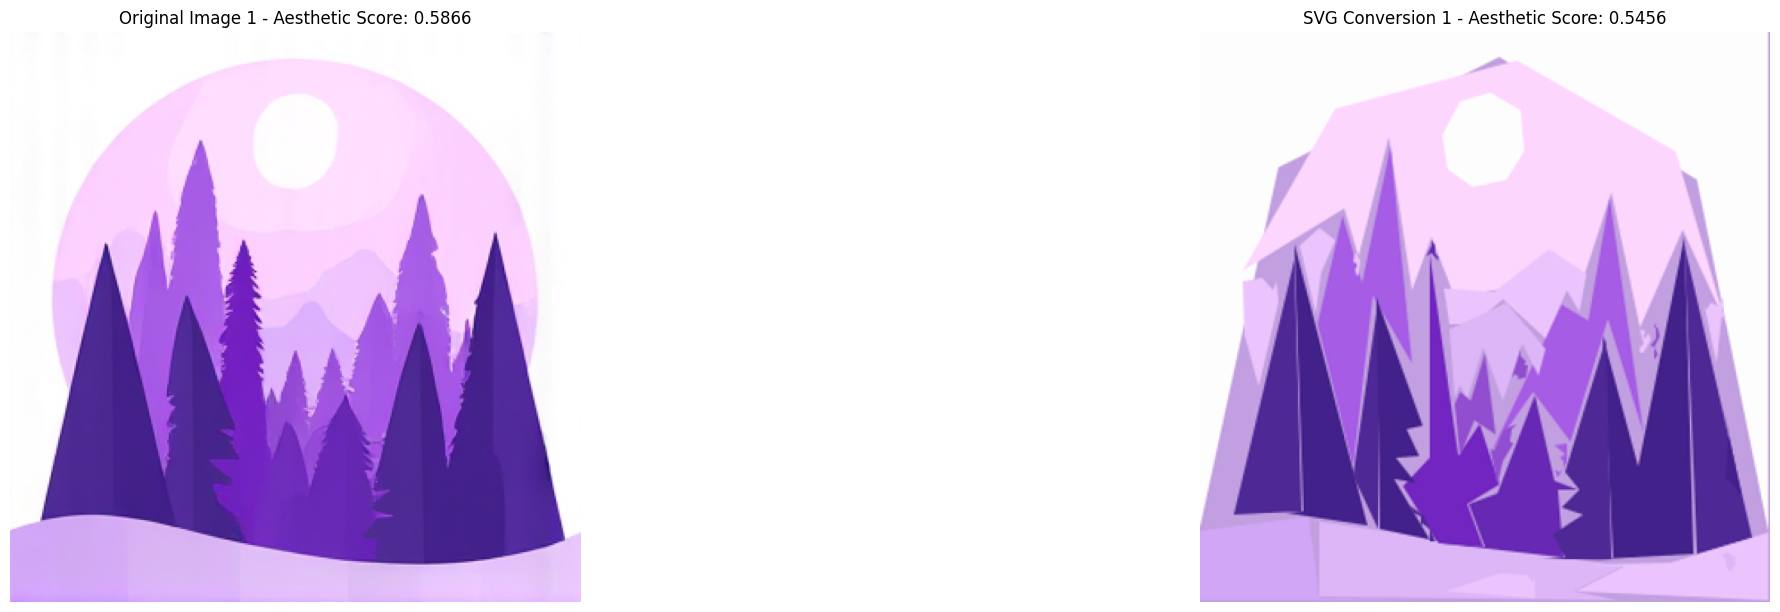

Time: 328.5864679813385s/image
SVG VQA Score: 0.5012
SVG Aesthetic Score: 0.5456
SVG Ocr Score: 1.0000
SVG Total Score: 0.5095
✅ New best result
-------------------------------------------

=== Attempt 1/1 ===
Description: gray wool coat with a faux fur collar



  0%|          | 0/10 [00:00<?, ?it/s]

Converting to SVG... SVG size: 1740 bytes


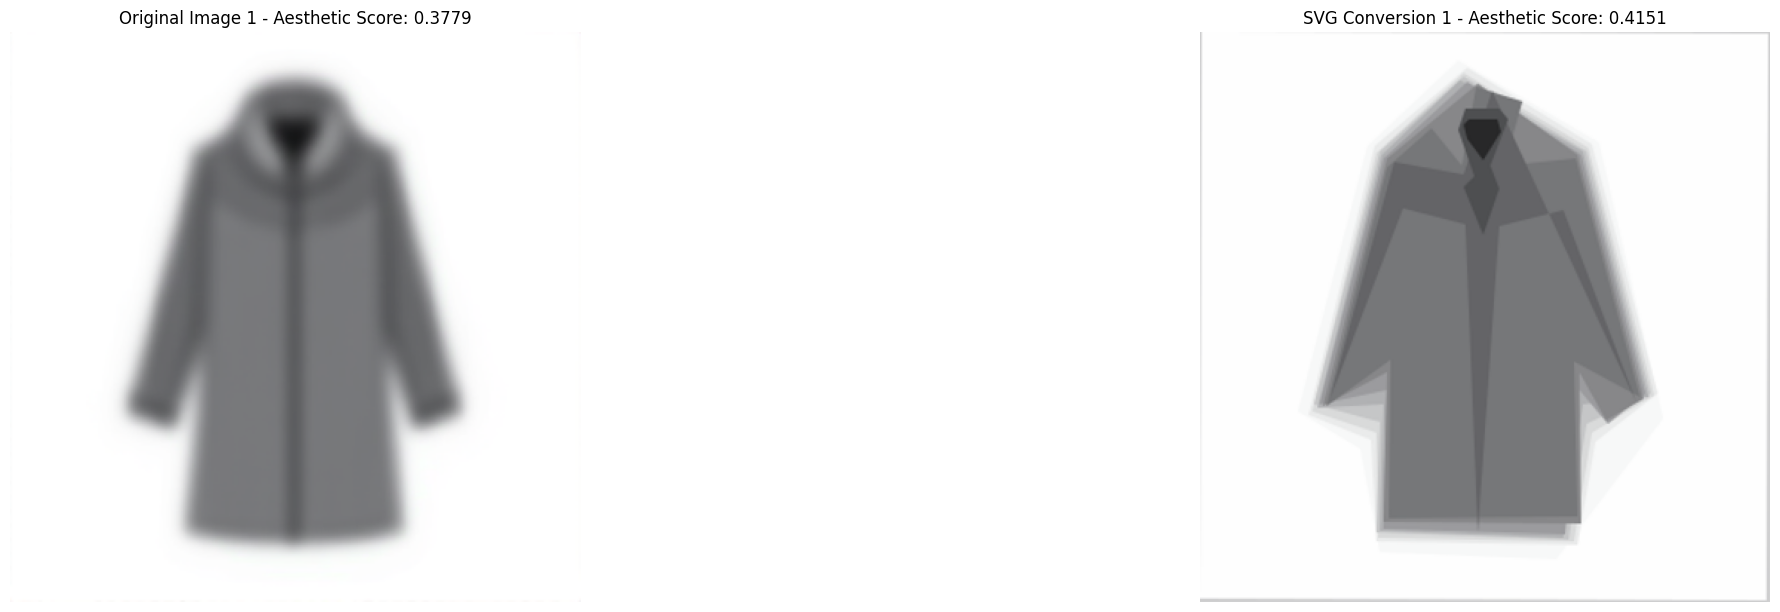

Time: 99.73255610466003s/image
SVG VQA Score: 0.9974
SVG Aesthetic Score: 0.4151
SVG Ocr Score: 1.0000
SVG Total Score: 0.7789
✅ New best result
-------------------------------------------

=== Attempt 1/1 ===
Description: a lighthouse overlooking the ocean



  0%|          | 0/10 [00:00<?, ?it/s]

Converting to SVG... SVG size: 4232 bytes


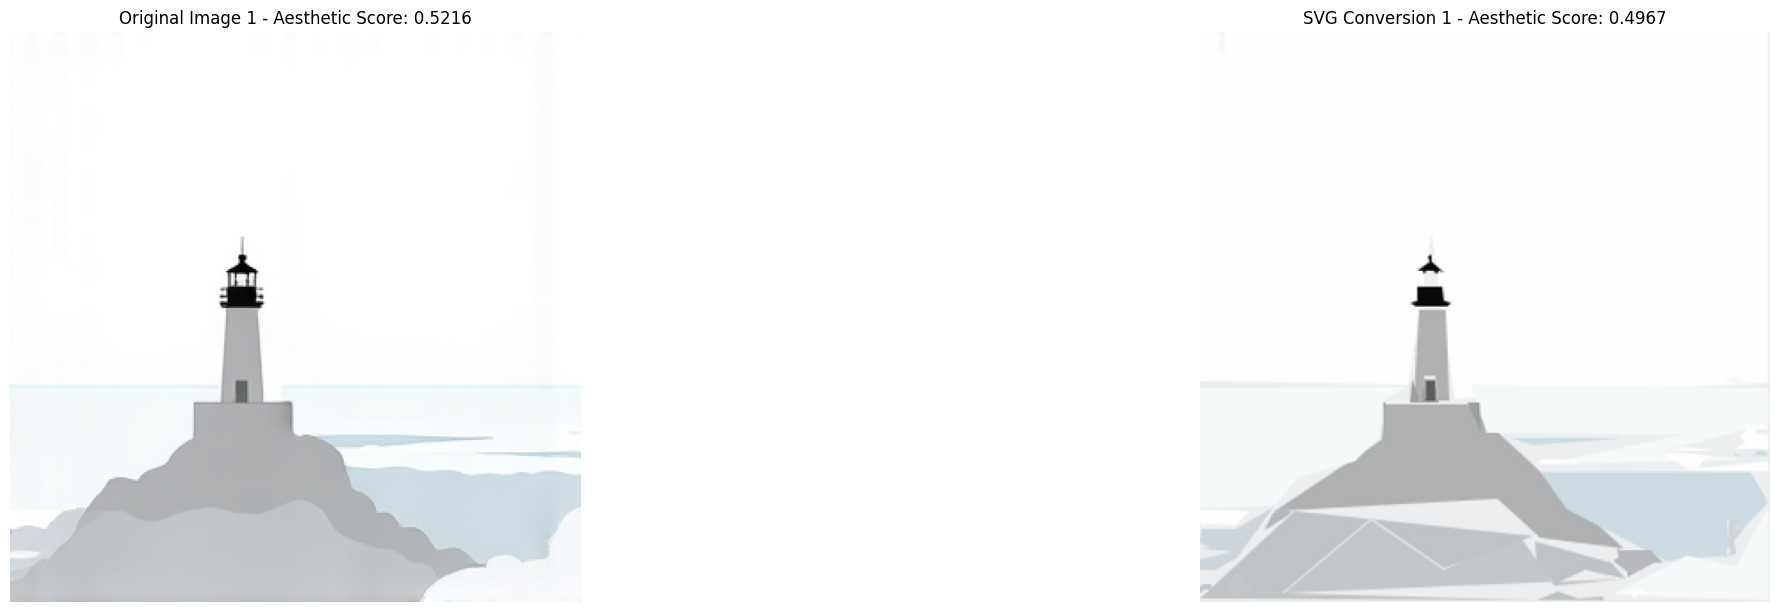

Time: 99.34985065460205s/image
SVG VQA Score: 0.8886
SVG Aesthetic Score: 0.4967
SVG Ocr Score: 1.0000
SVG Total Score: 0.7675
✅ New best result
-------------------------------------------

=== Attempt 1/1 ===
Description: burgundy corduroy pants with patch pockets and silver buttons



  0%|          | 0/10 [00:00<?, ?it/s]

Converting to SVG... SVG size: 2898 bytes


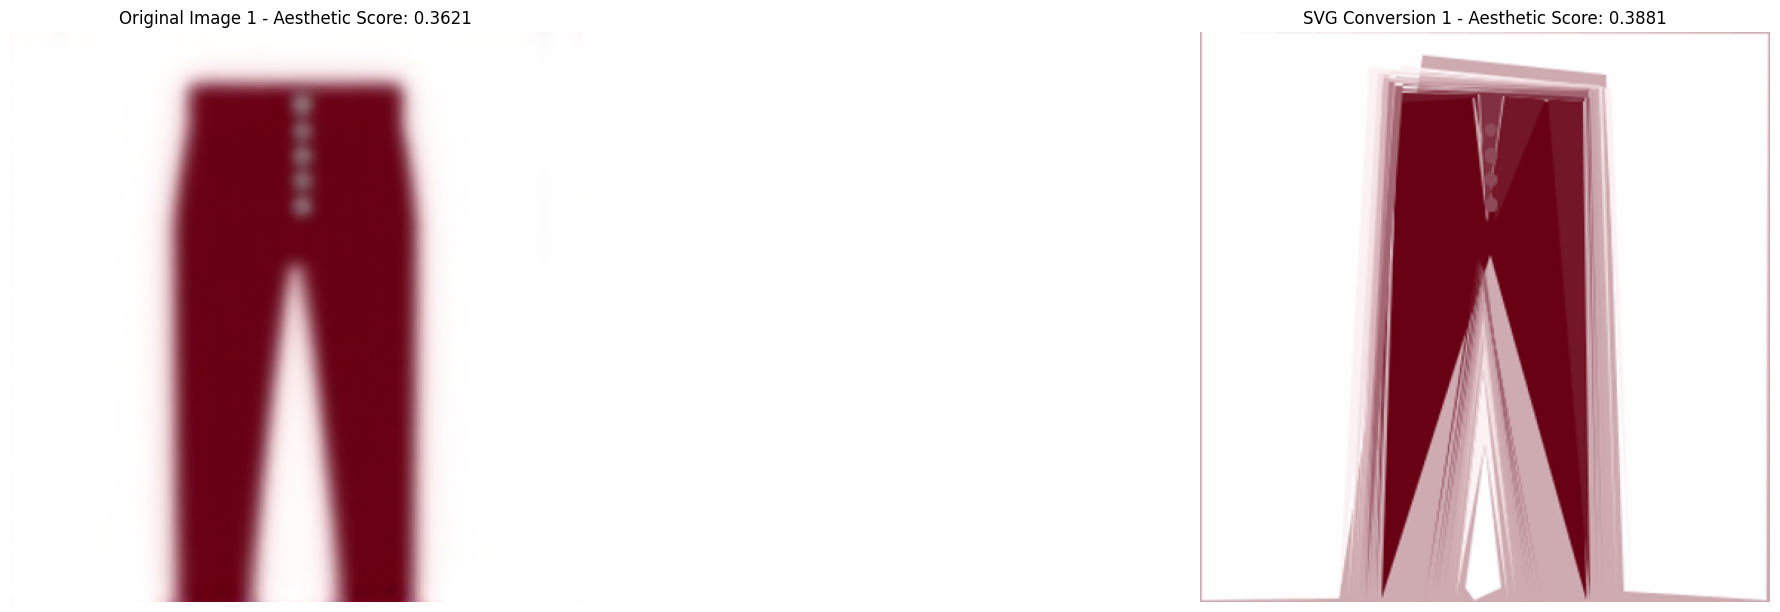

Time: 99.36957812309265s/image
SVG VQA Score: 0.7467
SVG Aesthetic Score: 0.3881
SVG Ocr Score: 1.0000
SVG Total Score: 0.6303
✅ New best result
-------------------------------------------

=== Attempt 1/1 ===
Description: orange corduroy overalls



  0%|          | 0/10 [00:00<?, ?it/s]

Converting to SVG... SVG size: 1665 bytes


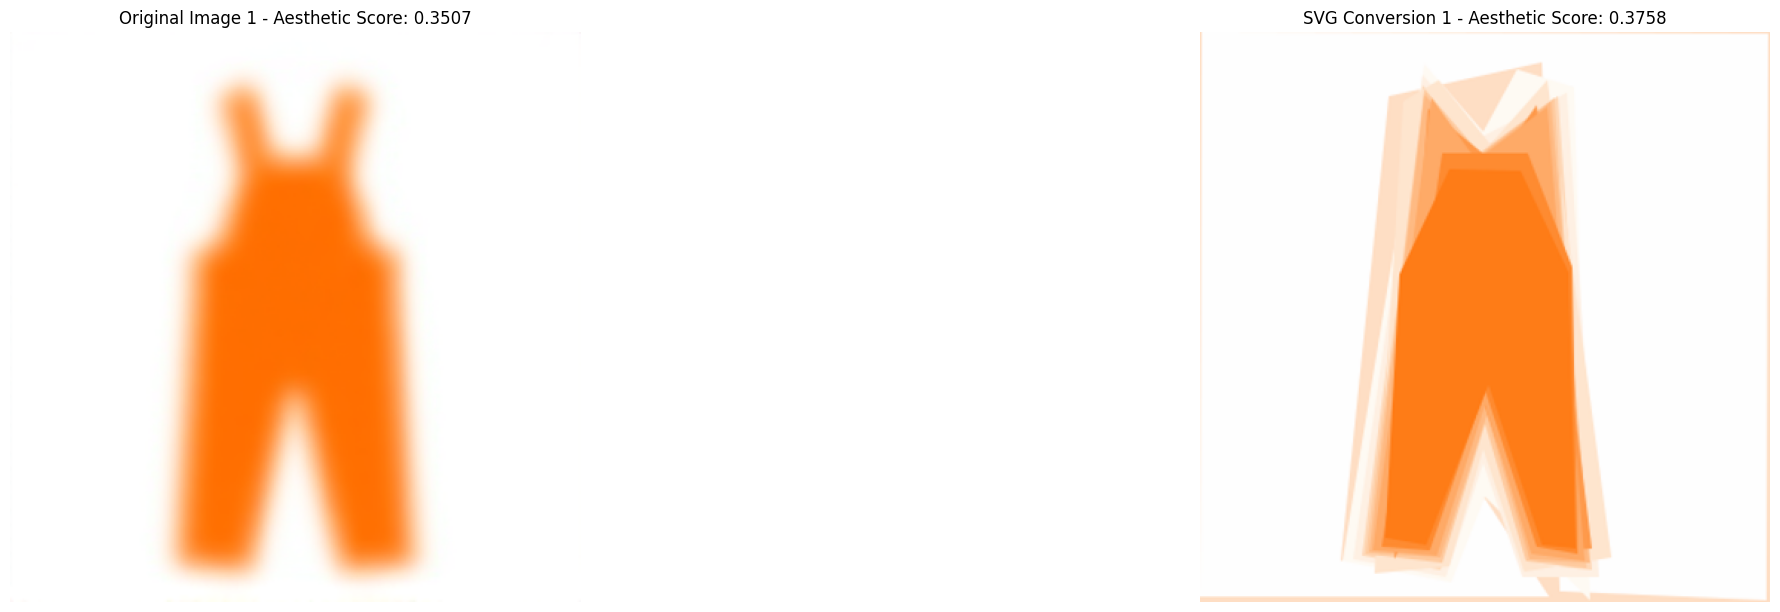

Time: 99.3858323097229s/image
SVG VQA Score: 0.8171
SVG Aesthetic Score: 0.3758
SVG Ocr Score: 1.0000
SVG Total Score: 0.6617
✅ New best result
-------------------------------------------

=== Attempt 1/1 ===
Description: a purple silk scarf with tassel trim



  0%|          | 0/10 [00:00<?, ?it/s]

Converting to SVG... SVG size: 2624 bytes


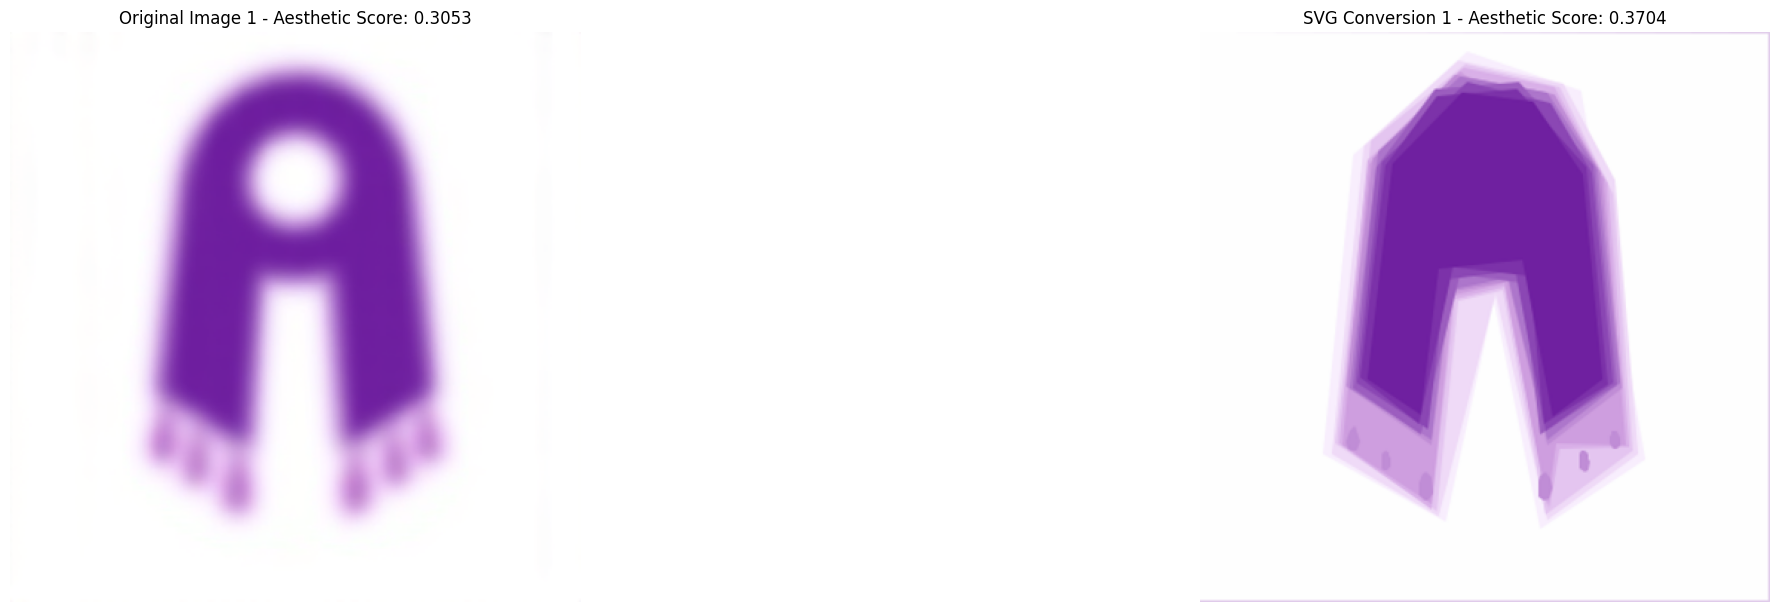

Time: 99.4161548614502s/image
SVG VQA Score: 0.5338
SVG Aesthetic Score: 0.3704
SVG Ocr Score: 1.0000
SVG Total Score: 0.4905
✅ New best result
-------------------------------------------

=== Attempt 1/1 ===
Description: a green lagoon under a cloudy sky



  0%|          | 0/10 [00:00<?, ?it/s]

Converting to SVG... SVG size: 2414 bytes


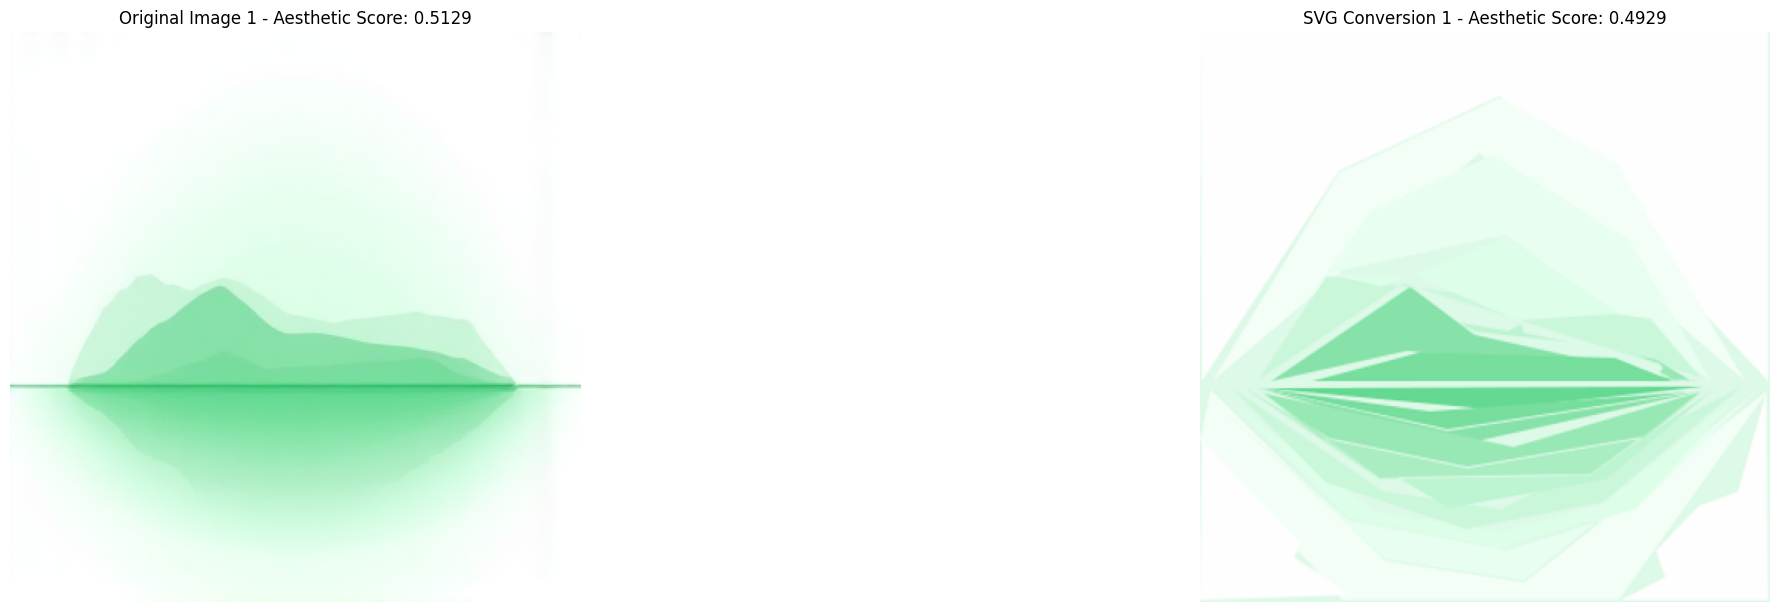

Time: 99.33564448356628s/image
SVG VQA Score: 0.7526
SVG Aesthetic Score: 0.4929
SVG Ocr Score: 1.0000
SVG Total Score: 0.6808
✅ New best result
-------------------------------------------

=== Attempt 1/1 ===
Description: crimson rectangles forming a chaotic grid



  0%|          | 0/10 [00:00<?, ?it/s]

Converting to SVG... SVG size: 9992 bytes


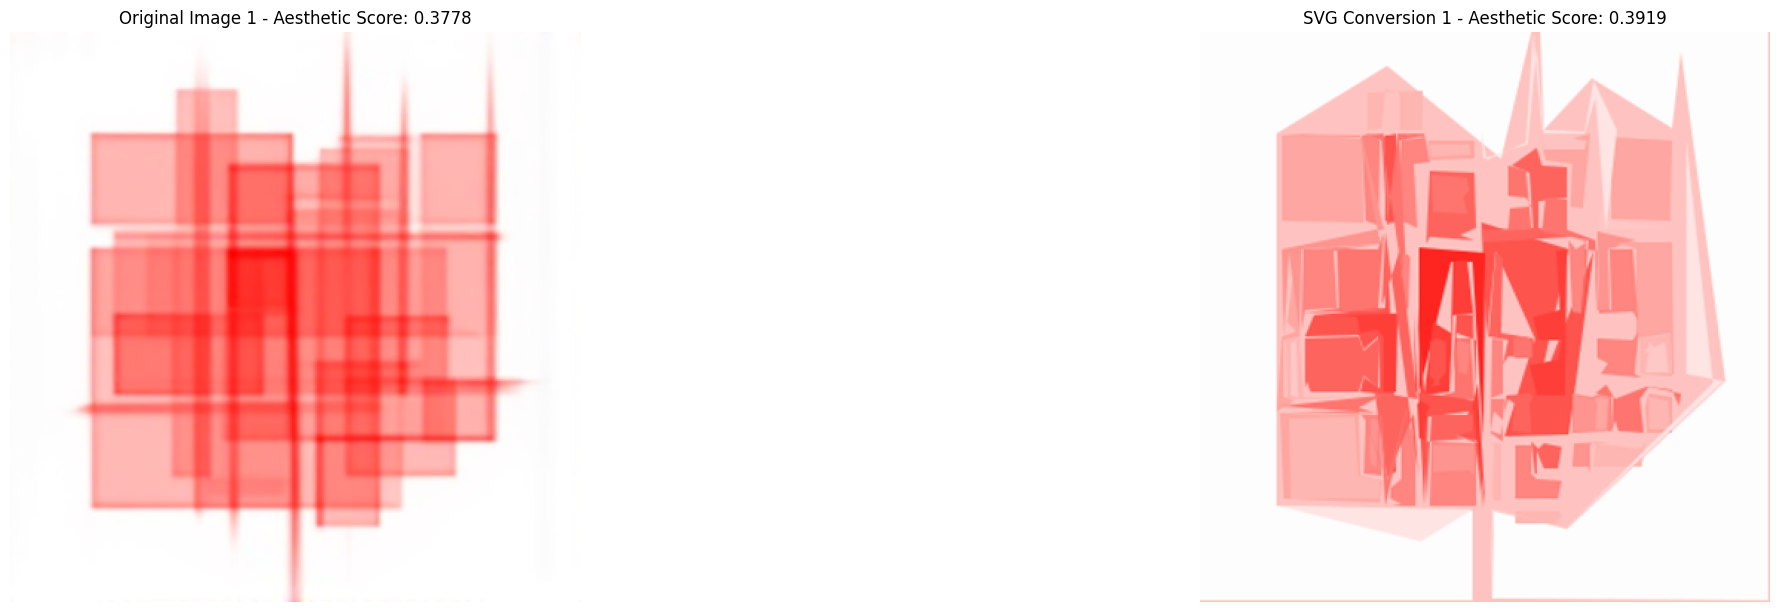

Time: 99.24683237075806s/image
SVG VQA Score: 0.7519
SVG Aesthetic Score: 0.3919
SVG Ocr Score: 1.0000
SVG Total Score: 0.6352
✅ New best result
-------------------------------------------

=== Attempt 1/1 ===
Description: purple pyramids spiraling around a bronze cone



  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
results = []

for i, idx_prompt in enumerate(train_df['id']):
    result = generate_and_image_in_train(
        idx_prompt=idx_prompt,
        data=train_df,
        generate_bitmap=generate_bitmap,
        prefix_prompt=prefix_prompt, 
        negative_prompt=negative_prompt, 
        suffix_prompt=suffix_prompt, 
        num_inference_steps=10, 
        guidance_scale=7.5, 
        num_attempts=1, 
        use_image_compression=False,
        use_model="Flux",
        verbose=True,
        random_seed=42,
    )
    
    output = {
        'id_result': i,
        'id_prompt': id_prompt,
        **result  # unpack tất cả key-value trong result vào output
    }
    
    results.append(output)

save_results_to_json(results, PATH_NO_COMPRESSION_IMAGE)

In [ ]:
results = []

for i, idx_prompt in enumerate(train_df['id']):
    result = generate_and_image_in_train(
        idx_prompt=idx_prompt,
        data=train_df,
        generate_bitmap=generate_bitmap,
        prefix_prompt=prefix_prompt, 
        negative_prompt=negative_prompt, 
        suffix_prompt=suffix_prompt, 
        num_inference_steps=10, 
        guidance_scale=7.5, 
        num_attempts=1, 
        use_image_compression=True,
        use_model="Flux",
        verbose=True,
        random_seed=42,
    )
    
    output = {
        'id_result': i,
        'id_prompt': id_prompt,
        **result  # unpack tất cả key-value trong result vào output
    }
    
    results.append(output)
    
save_results_to_json(results, PATH_HAVE_COMPRESSION_IMAGE)